# Initialize data

In [45]:
import glmhmm 
import numpy as np
import sys
sys.path.append('/src/tools/flytrack/model/')
print(sys.path)
from fitting import *
from analysis import find_permutation, evaluate_classification, calculate_match_rate, matrix_comp
from sklearn.metrics import r2_score

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/src/tools/flytrack/model/', '/data/users/weixuan/work', '/src/tools/flytrack/model/', '/src/tools/flytrack/', '/data/users/weixuan/work/data', '/src/tools/flytrack/model/', '/src/tools/flytrack/model/', '/src/tools/flytrack/model/', '/src/tools/flytrack/model/']


## load trajectory and neural data

based on /src/tools/pybounds/examples/observability_analysis_dynamic_wind.ipynb

In [ ]:
obs_pkls = ['/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_observability_test.pkl',
# obs_pkls = ['/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_original_inits_observability_test.pkl',
            '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_17519_6aca800e09d4942c5d296ae7157fcf8b/noisy3x5b5_observability_test.pkl']
eval_pkls = [obs_pkl.replace("_observability_test.pkl", ".pkl") for obs_pkl in obs_pkls]

# load pkl file
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tamagotchi.eval.log_analysis as log_analysis

with open(obs_pkls[0], 'rb') as f_handle:
    observability_tupl = pickle.load(f_handle)
    print(len(observability_tupl))
with open(eval_pkls[0], 'rb') as f_handle:
    # based on open_loop_perturbation.py
    dataset = 'noisy3x5b5'
    eval_folder = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/'
    # eval_folder = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_17519_6aca800e09d4942c5d296ae7157fcf8b/'
    selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                            n_episodes_home=240,
                                            n_episodes_other=240,  
                                            balanced=False,
                                            oob_only=False,
                                            verbose=True,
                                            log_fname='/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5.pkl')
                                            # log_fname='/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_original_inits.pkl')

    traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                obtain_neural_activity = True, 
                                                                                                obtain_traj_df = True, 
                                                                                                get_traj_tmp = True,
                                                                                                extended_metadata = True) # get_traj_tmp 
    print(traj_df_stacked.shape)
    print(stacked_neural_activity.shape)
# for item in observability_tupl:
#     EV_no_nan, t_sim, x_sim, window_size, eps_idx = item
    
# ls_EV_no_nan, ls_t_sim, ls_x_sim, ls_window_size, ls_eps_idx = zip(*observability_tupl)

# Preprocess the trajectory data
# select episodes that have observability matrices
# eps_at = [True if ep_i in ls_eps_idx else False for ep_i in traj_df_stacked['ep_idx'] ]
eps_at = [True for ep_i in traj_df_stacked['ep_idx']]
subset_traj_df_stacked = traj_df_stacked[eps_at]
subset_stacked_neural_activity = stacked_neural_activity[eps_at]

# for every episode, drop the last row
subset_traj_df_stacked.reset_index(drop=True, inplace=True)
last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
print('dropping', len(last_rows), 'rows')
# drop the last row of each episode
filtered_df = subset_traj_df_stacked.drop(index=last_rows)
filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

# calculate time since last wind change
    # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

# create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
filtered_df['time'] = filtered_df['time'].round(2)

print("filtered_df shape", filtered_df.shape)
print("filtered_neural_activity shape", filtered_neural_activity.shape)

40
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5.pkl, after filter by min 0 steps
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME     160        160  160
           OOB       74         74   74
           OOT        6          6    6 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5.pkl, after selecting specific number of episodes
model_dir /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e

240it [00:05, 40.07it/s]


(40891, 89)
(40891, 64)
dropping 40 rows
filtered_df shape (10608, 91)
filtered_neural_activity shape (10608, 64)


## load observability data

In [3]:
# Preprocess the EV data 
# stack the EV data
ls_EV_no_nan = [df.assign(ep_idx=ep_idx) for df, ep_idx in zip(ls_EV_no_nan, ls_eps_idx)]
EV_no_nan = pd.concat(ls_EV_no_nan)
print(EV_no_nan.shape)
# Merge with filtered_dfa
EV_no_nan['time'] = EV_no_nan['time'].round(2)
EV_no_nan = EV_no_nan.merge(filtered_df[['ep_idx', 'time', 'time_since_last_wind_change', 'odor_01']], on=['ep_idx', 'time'], how='inner')
print(EV_no_nan.shape)
# EV_no_nan.sort_values(by=['ep_idx', 'time'], inplace=True)
# EV_no_nan.groupby('ep_idx')['time'].diff().value_counts() # checks out

(10608, 7)
(10608, 9)


## Construct obs df

In [35]:
# Preprocess action data
# get speed and acceleration
obs_df = pd.DataFrame()
obs_df['ep_idx'] = filtered_df['ep_idx']
obs_df['time'] = filtered_df['time']
obs_df['step'] = filtered_df['step'] # squashed action
obs_df['step_dt'] = obs_df.groupby('ep_idx')['step'].diff()
obs_df['speed'] = filtered_df['step']*2 # in m/s unit
obs_df['acceleration'] = obs_df.groupby('ep_idx')['speed'].diff()
obs_df['turn'] = filtered_df['turn']
obs_df['angular_velocity_turn'] = ((filtered_df['turn'] - 0.5)*2) * (6*np.pi) # in rad/s unit

# obs_df['acceleration'] = obs_df['acceleration'].fillna(0) # TODO check timing 

# calculate angular velocity and angular acceleration
obs_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
obs_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
obs_df['angular_velocity'] = obs_df.groupby('ep_idx')['heading_phi_unwrap'].diff()
obs_df['angular_acceleration'] = obs_df.groupby('ep_idx')['angular_velocity'].diff()
# obs_df['angular_acceleration'] = obs_df['angular_acceleration'].fillna(0) # TODO check timing

obs_df.head()
# obs_df['speed'].hist()


,ep_idx,time,step,step_dt,speed,acceleration,turn,angular_velocity_turn,heading_phi,heading_phi_unwrap,angular_velocity,angular_acceleration
0,83,0.00,0.243873,NaN,0.487745,NaN,0.096631,-15.206658,-0.316805,-0.316805,NaN,NaN
1,83,0.04,0.352573,0.108700,0.705146,0.217401,0.077069,-15.944136,-0.648975,-0.648975,-0.332170,NaN
2,83,0.08,0.449508,0.096935,0.899016,0.193870,0.115408,-14.498775,-0.951033,-0.951033,-0.302058,0.030112
3,83,0.12,0.395366,-0.054142,0.790732,-0.108284,0.122506,-14.231187,-1.247516,-1.247516,-0.296483,0.005575
4,83,0.16,0.372357,-0.023009,0.744713,-0.046018,0.107094,-14.812205,-1.556103,-1.556103,-0.308588,-0.012105


## Construct input df for glmhmm

In [ ]:
input_df = pd.DataFrame()
# observations of the agent
input_df['ep_idx'] = filtered_df['ep_idx']
input_df['time'] = filtered_df['time']
input_df['app_wind_x'] = filtered_df['wind_x_obs']
input_df['app_wind_y'] = filtered_df['wind_y_obs']
input_df['odor'] = filtered_df['odor_eps_log']
input_df['allo_head_phi_x'] = filtered_df['agent_angle_x']
input_df['allo_head_phi_y'] = filtered_df['agent_angle_y']
input_df['ego_drift_x'] = filtered_df['ego_course_direction_x']
input_df['ego_drift_y'] = filtered_df['ego_course_direction_y']
# possible latents to include
# input_df['min_EV_zeta'] = EV_no_nan['zeta']
# input_df['time_since_last_wind_change'] = EV_no_nan['time_since_last_wind_change']
input_df['acceleration'] = obs_df['acceleration']
input_df['angular_acceleration'] = obs_df['angular_acceleration']

input_df.head()


,ep_idx,time,app_wind_x,app_wind_y,odor,allo_head_phi_x,allo_head_phi_y,ego_drift_x,ego_drift_y,acceleration,angular_acceleration
0,83,0.00,2.123532,5.307983e-13,0.003922,0.950235,-0.311533,0.862312,0.506378,NaN,NaN
1,83,0.04,1.702489,7.969043e-13,0.004154,0.796704,-0.604370,0.812999,0.582265,NaN,NaN
2,83,0.08,1.327018,1.034208e-12,0.006039,0.580843,-0.814016,0.842580,0.538571,0.193870,0.030112
3,83,0.12,1.536733,9.016646e-13,0.006771,0.317679,-0.948198,0.775901,0.630855,-0.108284,0.005575
4,83,0.16,1.625858,8.453364e-13,0.007782,0.014692,-0.999892,0.753328,0.657645,-0.046018,-0.012105


## drop NaNs merge all dfs

In [50]:
# drop rows with NaN
input_df.dropna(inplace=True)
print(input_df.shape)
obs_df.dropna(inplace=True)
print(obs_df.shape)

df = input_df.merge(obs_df, on=['ep_idx', 'time'], how='inner')
df = df.merge(EV_no_nan, on=['ep_idx', 'time'], how='inner')
print(df.shape)

(10528, 11)
(10528, 12)
(10528, 28)


# init. model

## load fitted model

In [16]:
import os
import re
import numpy as np
from pathlib import Path
import sys
import pandas as pd 
sys.path.append('/src/tools/flytrack/model/')
print(sys.path)
from fitting import *
from analysis import find_permutation, evaluate_classification, calculate_match_rate, matrix_comp
# from visualize import plot_model_params, plot_loglikelihoods, plot_weights # NOTE dependency issues - weixuan new scripts same name as original; original scripts not included 

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/src/tools/flytrack/model/', '/data/users/weixuan/work', '/src/tools/flytrack/model/', '/src/tools/flytrack/', '/data/users/weixuan/work/data', '/src/tools/flytrack/model/', '/src/tools/flytrack/model/']


In [17]:
# find saved models in the directory
# result_dir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/'
result_dirs = ['/src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed4176ba/',
               '/src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed15113f/',
               '/src/data/published_results/reproduce/best_agents/plume_20230927_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed29882bb/']
result_dir = Path(result_dirs[0])
# find files that end in npz
model_type = 'GLMHMM'
# config_type = 'time_history'
config_type = 'baseline'
# Recursively find all .npz files
npz_files = list(result_dir.rglob('*.npz'))
print(f"Found {len(npz_files)} npz files")
# Sort the files
npz_files.sort()
files = {}
for f in npz_files:
    if model_type in str(f):
        # find index of model type
        idx = str(f).index(model_type)
        config = str(f)[idx:].split('/')[1]
        if config not in files:
            files[config] = []
        files[config].append(f)
        
print(files.keys())
# see which files are found
for key in files.keys():
    print(key, len(files[key]))

# load files 
keys = ['A_init', 'w_init', 'pi0_init', 'A_pred', 'w_pred', 'pi0_pred', 'train_idx', 'test_idx', 'input_names', 'obs_names', 'lls_pred', 'covariances']
A_init_all = []
w_init_all = []
pi0_init_all = []
A_pred_all = []
w_pred_all = []
pi0_pred_all = []
train_idx_all = []
test_idx_all = []
input_names_all = []
obs_names_all = []
lls_pred_all = []
covariances_all = []

fitted_models = [A_init_all, w_init_all, pi0_init_all, A_pred_all, w_pred_all, pi0_pred_all, train_idx_all, test_idx_all, input_names_all, obs_names_all, lls_pred_all, covariances_all]
for f in files[config_type]:
    print(f)
    f_loaded = np.load(f)
    # f_loaded = np.load(os.path.join(result_dir, f))
    for i, key in enumerate(keys):
        if key in f_loaded:
            # print(f"{key} found in {f}")
            loaded_shape = f_loaded[key].shape
            shapes = [j.shape[-len(loaded_shape):] for j in fitted_models[i]]
            if loaded_shape not in shapes:
                if str(f_loaded[key].dtype).startswith('<U'):
                    arr = np.zeros((1, *f_loaded[key].shape), dtype='<U15')
                else:
                    arr = np.zeros((1, *f_loaded[key].shape))
                arr[0] = f_loaded[key]
                fitted_models[i].append(arr)
            else:
                idx = shapes.index(f_loaded[key].shape)
                arr = fitted_models[i][idx]
                f_key = np.expand_dims(f_loaded[key], axis=0)
                arr = np.vstack([arr, f_key])
                fitted_models[i][idx] = arr
        else:
            print(f"{key} not in {f}")
print('shape dimensions: ("num_models, num_states, num_obs_features")')
for j, ls in enumerate(fitted_models):
    for i, arr in enumerate(ls):
        print(keys[j], "shape", arr.shape)

Found 18 npz files
dict_keys(['baseline', 'time_history'])
baseline 9
time_history 9
/src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed4176ba/behavioral_analysis/GLMHMM/baseline/K_2_seed_1/HMMGLM_seed4176ba_randSeed1_K2.npz
/src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed4176ba/behavioral_analysis/GLMHMM/baseline/K_2_seed_2/HMMGLM_seed4176ba_randSeed2_K2.npz
/src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed4176ba/behavioral_analysis/GLMHMM/baseline/K_2_seed_3/HMMGLM_seed4176ba_randSeed3_K2.npz
/src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoo

## load traj and neural data

In [18]:
from tamagotchi.eval import log_analysis
dataset = 'noisy3x5b5'
eval_pkls = list(result_dir.rglob('*.pkl'))
eval_pkls = [f for f in eval_pkls if f"{dataset}.pkl" in str(f)]
print(f"Found {len(eval_pkls)} eval pkls. eval_pkls: {eval_pkls}")
with open(eval_pkls[0], 'rb') as f_handle:
    # based on open_loop_perturbation.py
    selected_df = log_analysis.get_selected_df(str(result_dir), [dataset],
                                            n_episodes_home=240,
                                            n_episodes_other=0,  
                                            balanced=False,
                                            oob_only=False,
                                            verbose=True)

    traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                obtain_neural_activity = True, 
                                                                                                obtain_traj_df = True, 
                                                                                                get_traj_tmp = True,
                                                                                                extended_metadata = True) # get_traj_tmp 
    print(traj_df_stacked.shape)
    print(stacked_neural_activity.shape)

# NOT filtering eps by observability results 
eps_at = [True for ep_i in traj_df_stacked['ep_idx']]
subset_traj_df_stacked = traj_df_stacked[eps_at]
subset_stacked_neural_activity = stacked_neural_activity[eps_at]

# for every episode, drop the last row
subset_traj_df_stacked.reset_index(drop=True, inplace=True)
last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
print('dropping', len(last_rows), 'rows')
filtered_df = subset_traj_df_stacked.drop(index=last_rows)
filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

# calculate time since last wind change
    # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

# create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
filtered_df['time'] = filtered_df['time'].round(2)

print("filtered_df shape", filtered_df.shape)
print("filtered_neural_activity shape", filtered_neural_activity.shape)


Found 1 eval pkls. eval_pkls: [PosixPath('/src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed4176ba/noisy3x5b5.pkl')]
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME      60         60   60
           OOB      173        173  173
           OOT        7          7    7 in /src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed4176ba/noisy3x5b5.pkl, after filter by min 0 steps
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME      60         60   60
           OOB      173        173  173
           OOT        7          7    7 in /src/data/published_results/reproduce/best_agents/plume_20230923_VRNN_constantx5b5noisy3x5b5_stepo

60it [00:02, 28.65it/s]


(12071, 82)
(12071, 64)
dropping 60 rows
filtered_df shape (12011, 84)
filtered_neural_activity shape (12011, 64)


### make obs input dfs which were used to fit the model

In [19]:
from JH_model_fitting import create_history_by_group

In [20]:

# Preprocess action data
# get speed and acceleration
obs_df = pd.DataFrame()
obs_df['ep_idx'] = filtered_df['ep_idx']
obs_df['time'] = filtered_df['time']
obs_df['step'] = filtered_df['step'] # squashed action
obs_df['step_dt'] = obs_df.groupby('ep_idx')['step'].diff()
obs_df['speed'] = filtered_df['step']*2 # in m/s unit
obs_df['acceleration'] = obs_df.groupby('ep_idx')['speed'].diff()
obs_df['turn'] = filtered_df['turn']
obs_df['angular_velocity_turn'] = ((filtered_df['turn'] - 0.5)*2) * (6*np.pi) # in rad/s unit

# obs_df['acceleration'] = obs_df['acceleration'].fillna(0) # TODO check timing 

# calculate angular velocity and angular acceleration
obs_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
obs_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
obs_df['angular_velocity'] = obs_df.groupby('ep_idx')['heading_phi_unwrap'].diff()
obs_df['angular_acceleration'] = obs_df.groupby('ep_idx')['angular_velocity'].diff()
# obs_df['angular_acceleration'] = obs_df['angular_acceleration'].fillna(0) # TODO check timing

obs_df.head()

input_df = pd.DataFrame()
# observations of the agent
input_df['ep_idx'] = filtered_df['ep_idx']
input_df['time'] = filtered_df['time']
input_df['app_wind_x'] = filtered_df['wind_x_obs']
input_df['app_wind_y'] = filtered_df['wind_y_obs']
if 'odor_eps_log' in filtered_df.columns:
    input_df['odor'] = filtered_df['odor_eps_log'] # new agents - logged odor
else:
    input_df['odor'] = filtered_df['odor_clip'] # old agents - norm'd odor and theb clipped
input_df['allo_head_phi_x'] = filtered_df['agent_angle_x']
input_df['allo_head_phi_y'] = filtered_df['agent_angle_y']
if 'ego_course_direction_x' in filtered_df.columns:
    input_df['ego_drift_x'] = filtered_df['ego_course_direction_x']
    input_df['ego_drift_y'] = filtered_df['ego_course_direction_y']
# possible latents to include
# input_df['min_EV_zeta'] = EV_no_nan['zeta']
# input_df['time_since_last_wind_change'] = EV_no_nan['time_since_last_wind_change']
input_df['acceleration'] = obs_df['acceleration']
input_df['angular_acceleration'] = obs_df['angular_acceleration']
input_df['odor_lastenc'] = filtered_df['odor_lastenc']
input_df['step'] = obs_df['step']
input_df['turn'] = obs_df['turn']

input_df.head()



,ep_idx,time,app_wind_x,app_wind_y,odor,allo_head_phi_x,allo_head_phi_y,acceleration,angular_acceleration,odor_lastenc,step,turn
0,3,0.00,1.001121,0.535646,1.000000,0.949685,0.313208,NaN,NaN,0,0.983782,0.905614
1,3,0.04,0.926843,0.636337,1.000000,0.902671,0.430332,0.019433,NaN,0,0.993499,0.660800
2,3,0.08,0.902458,0.688246,1.000000,0.920019,0.391874,0.001267,-0.168484,0,0.994133,0.446278
3,3,0.12,0.911970,0.662814,1.000000,0.912021,0.410143,-0.000383,0.062136,0,0.993941,0.525392
4,3,0.16,0.983143,0.421114,0.130785,0.821114,0.570764,0.001396,0.164883,0,0.994639,0.735328


In [21]:
input_df = create_history_by_group(input_df, 
                                'ep_idx', 
                                    ['step', 'turn'], 
                                    6) 

### drop NaNs and merge all dfs

In [22]:
# drop rows with NaN
input_df.dropna(inplace=True)
print(input_df.shape)
obs_df.dropna(inplace=True)
print(obs_df.shape)

df = input_df.merge(obs_df, on=['ep_idx', 'time'], how='inner')
# df = df.merge(EV_no_nan, on=['ep_idx', 'time'], how='inner')
print(df.shape)

(11651, 24)
(11891, 12)
(11651, 34)


In [23]:
test_idx_all

[array([[358., 439., 421., 343.],
        [343., 466., 378., 243.],
        [280., 358., 293., 403.],
        [358., 439., 421., 343.],
        [343., 466., 378., 243.],
        [280., 358., 293., 403.],
        [358., 439., 421., 343.],
        [343., 466., 378., 243.],
        [280., 358., 293., 403.]])]

# evaluate models 

## load test data and make df

In [24]:
ith_model = 0
K = 3
# load the model weights with K states
for i, _ in enumerate(w_pred_all):
    num_models = _.shape[0]
    model_idx = [ith_model, ith_model+num_models] # note: only works if models paths are sorted by number of states after being scaned in
    ith_model += num_models # update ith_model for next K states
    print(i, _.shape, model_idx)
    if _.shape[1] == K: # find the model with K states (num_models, num_states, num_obs_features)
        K_w_pred = _
        K_A_pred = A_pred_all[i]
        K_pi0_pred = pi0_pred_all[i]
        K_covar = covariances_all[i]
        print("found model with K states", K_w_pred.shape, K_A_pred.shape, K_pi0_pred.shape, K_covar.shape)
        print("model_idx", model_idx)
        break

for i, ordinal_i in enumerate(range(*model_idx)):
    # load test data for model_i # HACK 
    test_idx = test_idx_all[0][ordinal_i] - 240 # 240 is the number of episodes in the training set - WRONGFULLY ADDED TO ALL IDX, actual number depends on the n_trials in hydra config
    input_names = input_names_all[0][ordinal_i]
    obs_names = obs_names_all[0][ordinal_i]
    print("model", ordinal_i, "test_idx", test_idx, "input_names", input_names, "obs_names", obs_names)
    X_test = df[input_names][df['ep_idx'].isin(test_idx)].values
    Y_test = df[obs_names][df['ep_idx'].isin(test_idx)].values
    # # X_test = input_df[input_names][input_df['ep_idx'].isin(test_idx)].values
    # # Y_test = obs_df[obs_names][obs_df['ep_idx'].isin(test_idx)].values
    df_test = df[df['ep_idx'].isin(test_idx)]
    df_test.dropna(inplace=True)
    print(X_test.shape, Y_test.shape, df_test.shape)
    
    w_pred = K_w_pred[i]
    A_pred = K_A_pred[i]
    pi0_pred = K_pi0_pred[i]
    covar = K_covar[i]
    N = X_test.shape[0] 
    D = X_test.shape[1] + 1 
    dim_output = Y_test.shape[1]
    # print(N, K, D, dim_output, covar)
    m = GLMHMM(N, K, D, dim_output, 0)
    m.transition_matrix = A_pred
    m.w = w_pred
    m.pi0 = pi0_pred
    m.covariances = covar
    pred_seq = m.mostprob_states(X_test, Y_test).astype(int)
    # plot the predicted sequence        
    timebin=N
    cmap = 'viridis'
    vmin, vmax = 0, np.max(pred_seq)

    plt.figure(figsize=(12, 4))
    # plt.title(f"true{true_i}, pred{pred_i}")
    plt.plot(range(N), pred_seq, 'red', label='pred')
    plt.legend()

    # plt.figure(figsize=(8, 6))
    # plt.subplot(311)
    # plt.imshow(pred_seq[None,:], aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
    # plt.xlim(0, timebin)
    # plt.ylabel("$z_{\\mathrm{true}}$")
    # plt.yticks([])
    # plt.xlim(0, 10)
    
    # state probabilities
    probs = m.compute_state_probability(X_test, Y_test)
    for state_i in range(probs.shape[1]):
        df_test[f'state_prob_{state_i}'] = probs[:, state_i]

    df_test['state']=pred_seq

    # plot the state probabilities as a line plot
    colors = ['r', 'g', 'b', 'y']
    labels = ['state 0', 'state 1', 'state 2', 'state 3']
    plt.figure(figsize=(12, 4))
    for i in range(K):
        plt.plot(range(N), probs[:, i], color=colors[i], label=labels[i])
    plt.xlabel('time')
    plt.ylabel('state probability')
    plt.title('state probabilities')
    plt.legend()

    pred_Y = m.predict_emissions(X_test, df_test['state'].values)
    for i, obs in enumerate(obs_names):
        df_test[f'{obs}_hat'] = pred_Y[:, i]
        df_test[f'{obs}_error'] = df_test[obs] - df_test[f'{obs}_hat']
        df_test[f'{obs}_error_abs'] = np.abs(df_test[f'{obs}_error'])
    # get R^2
    r2 = r2_score(Y_test, pred_Y)
    print(r2)
    # compare the predicted emissions with the true emissions
    plt.figure(figsize=(8, 6))
    plt.subplot(313)
    plt.plot(pred_Y[:, 0], label='predicted')
    plt.plot(Y_test[:, 0], label='true')
    plt.legend()
    plt.ylabel('step')
    plt.title('step prediction')

    # compare turn
    plt.figure(figsize=(8, 6))
    plt.subplot(313)
    plt.plot(pred_Y[:, 1], label='predicted')
    plt.plot(Y_test[:, 1], label='true')
    plt.legend()
    plt.ylabel('turn')
    plt.title('turn prediction')

    # compare the error
    plt.figure(figsize=(8, 6))
    plt.subplot(313)
    plt.plot(df_test['step_error_abs'].values, label='step')
    plt.legend()
    plt.ylabel('error')
    plt.title('abs step error')

    # compare the error
    plt.figure(figsize=(8, 6))
    plt.subplot(313)
    plt.plot(df_test['turn_error_abs'].values, label='turn')
    plt.legend()
    plt.ylabel('error')
    plt.title('abs turn error')




0 (3, 2, 5, 2) [0, 3]
1 (3, 3, 5, 2) [3, 6]
found model with K states (3, 3, 5, 2) (3, 3, 3) (3, 3) (3, 3, 2, 2)
model_idx [3, 6]
model 3 test_idx [118. 199. 181. 103.] input_names ['app_wind_x' 'app_wind_y' 'odor' 'odor_lastenc'] obs_names ['step' 'turn']


KeyError: "None of [Index(['step', 'turn'], dtype='object')] are in the [columns]"

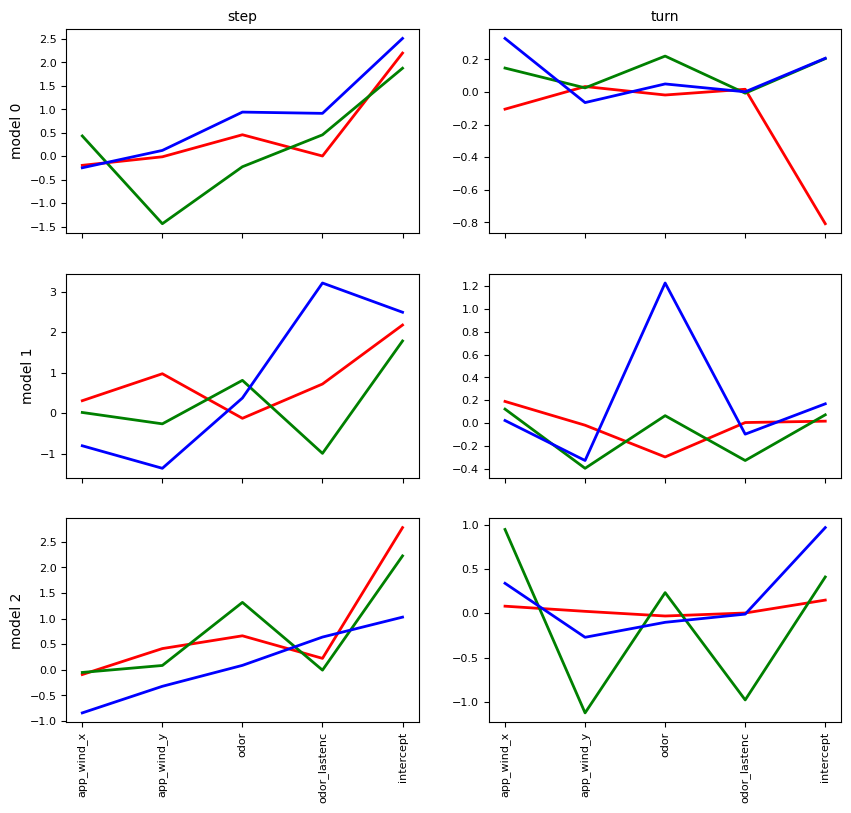

In [60]:
K_w_pred
# plot the inferred weights probabilities


fig, axes = plt.subplots(K_w_pred.shape[0],2)
# set figure size
fig.set_size_inches(10,9)
output_names=['step', 'turn']
colors = ['r', 'g', 'b', 'y']
labels = ['state 0', 'state 1', 'state 2', 'state 3']
for model_i in range(K_w_pred.shape[0]):
    w_pred = K_w_pred[model_i] # shape (3, 8, 2): K, D+1, dim_output
    for state_i in range(w_pred.shape[0]):
        for output_i in range(w_pred.shape[2]):
            ax = axes[model_i, output_i] # each model has its own row
            xlabels = list(input_names)
            xlabels.append('intercept')
            style = '-'
            # print("w_pred[state_i,:,output_i].shape", w_pred[state_i,:,output_i].shape)
            # print("labels[state_i]", labels[state_i])
            # print("colors[state_i]", colors[state_i])
            ax.plot(w_pred[state_i,:,output_i], style,linewidth=2, color=colors[state_i], label=labels[state_i]) #,color=color[i] label=label[i],
            # label x axis by name
            ax.set_xticks(np.arange(0,len(xlabels)))
            ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
            # change y ticks font
            ax.tick_params(axis='y', labelsize=8)
            # change y label font
            if output_i == 0:
                ax.set_ylabel(f"model {model_i}" , fontsize=10)
            if model_i == 0:
                ax.set_title(f'{output_names[output_i]}', fontsize=10)
            if model_i != K_w_pred.shape[0]-1:
                ax.set_xticklabels([])


## predict states

810 3 5 2
(810,)
148


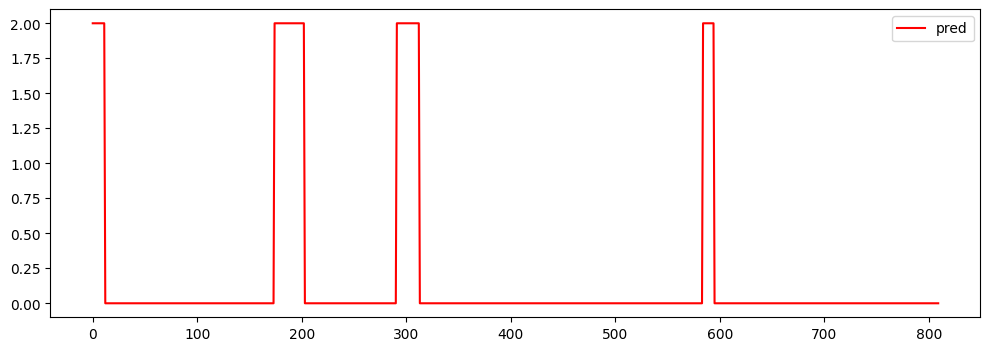

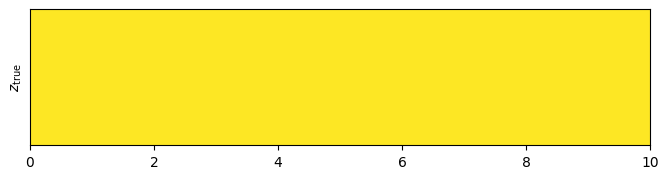

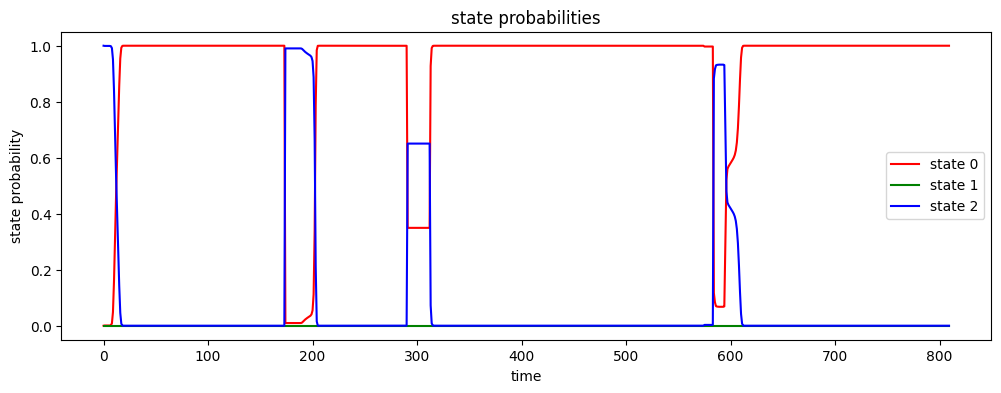

In [41]:
for model_i, w_pred in enumerate(w_pred_all):
    if w_pred.shape[1] == 3:
        w_pred_K3 = w_pred
        A_pred_K3 = A_pred_all[model_i]
        pi0_pred_K3 = pi0_pred_all[model_i]
        break
    
model_i = 1
w_pred = w_pred_K3[model_i]
A_pred = A_pred_K3[model_i]
pi0_pred = pi0_pred_K3[model_i] # TODO this is not saved normally
N = X_test.shape[0] 
K = A_pred_K3.shape[1]
D = X_test.shape[1] + 1 
dim_output = Y_test.shape[1]
covar_epsilon=0.02 # TODO: this needs to be saved after training
print(N, K, D, dim_output)
m = GLMHMM(N, K, D, dim_output, covar_epsilon)
m.transition_matrix = A_pred
m.w = w_pred
m.pi0 = pi0_pred
pred_seq = m.mostprob_states(X_test, Y_test).astype(int)

print(pred_seq.shape)
print(pred_seq.sum(axis=0))

timebin=N
cmap = 'viridis'
vmin, vmax = 0, np.max(pred_seq)

plt.figure(figsize=(12, 4))
# plt.title(f"true{true_i}, pred{pred_i}")
plt.plot(range(N), pred_seq, 'red', label='pred')
plt.legend()

plt.figure(figsize=(8, 6))
plt.subplot(311)
plt.imshow(pred_seq[None,:], aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
plt.xlim(0, timebin)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.xlim(0, 10)

## pred state prob

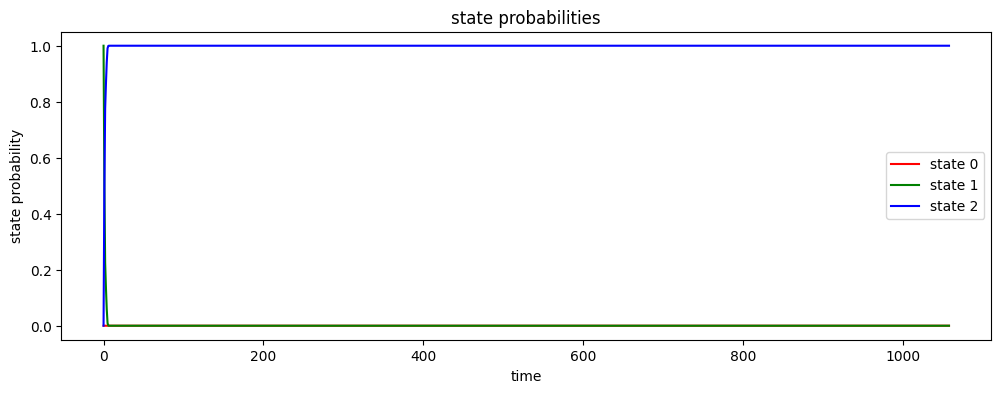

In [ ]:
probs = m.compute_state_probability(X_test, Y_test)
for state_i in range(probs.shape[1]):
    df_test[f'state_prob_{state_i}'] = probs[:, state_i]

df_test['state']=pred_seq

# plot the state probabilities as a line plot
colors = ['r', 'g', 'b']
labels = ['state 0', 'state 1', 'state 2']
plt.figure(figsize=(12, 4))
for i in range(K):
    plt.plot(range(N), probs[:, i], color=colors[i], label=labels[i])
plt.xlabel('time')
plt.ylabel('state probability')
plt.title('state probabilities')
plt.legend()

# plt.figure(figsize=(8, 6))
# plt.subplot(312)
# plt.imshow(probs.T, aspect="auto", cmap=cmap)
# plt.xlim(0, timebin)
# plt.ylabel("$p(z_{\\mathrm{true}})$")
# plt.yticks([])
# # what's this plotting?



## pred emissions

2856    0.964622
2857    0.978242
2858    0.975821
2859    0.966233
2860    0.959213
          ...   
7417    0.971061
7418    0.975568
7419    0.966845
7420    0.944634
7421    0.925934
Name: step, Length: 1059, dtype: float32

0.7698744750554499


Text(0.5, 1.0, 'abs turn error')

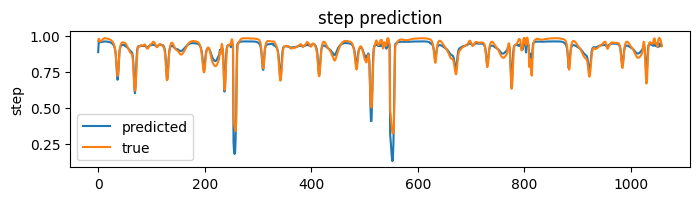

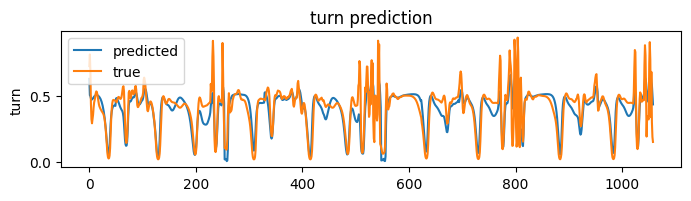

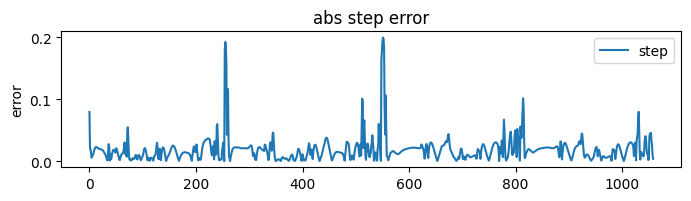

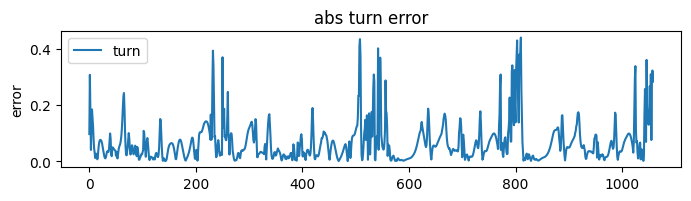

In [107]:
pred_Y = m.predict_emissions(X_test, df_test['state'].values)
for i, obs in enumerate(obs_names):
    df_test[f'{obs}_hat'] = pred_Y[:, i]
    df_test[f'{obs}_error'] = df_test[obs] - df_test[f'{obs}_hat']
    df_test[f'{obs}_error_abs'] = np.abs(df_test[f'{obs}_error'])
# get R^2
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, pred_Y)
print(r2)
# compare the predicted emissions with the true emissions
plt.figure(figsize=(8, 6))
plt.subplot(313)
plt.plot(pred_Y[:, 0], label='predicted')
plt.plot(Y_test[:, 0], label='true')
plt.legend()
plt.ylabel('step')
plt.title('step prediction')

# compare turn
plt.figure(figsize=(8, 6))
plt.subplot(313)
plt.plot(pred_Y[:, 1], label='predicted')
plt.plot(Y_test[:, 1], label='true')
plt.legend()
plt.ylabel('turn')
plt.title('turn prediction')

# compare the error
plt.figure(figsize=(8, 6))
plt.subplot(313)
plt.plot(df_test['step_error_abs'].values, label='step')
plt.legend()
plt.ylabel('error')
plt.title('abs step error')

# compare the error
plt.figure(figsize=(8, 6))
plt.subplot(313)
plt.plot(df_test['turn_error_abs'].values, label='turn')
plt.legend()
plt.ylabel('error')
plt.title('abs turn error')


# around wind change

## preprocess

In [108]:
# based on /src/tools/pybounds/examples/observability_visualize.ipynb 022025
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, drop_close_to_trial_init=False, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
        # drop_close_to_trial_init: plot_tidx marking is invalid if the wind change time is too close to the trial init, -40 plot_tidx could mean 0.8s from the last wind change
            # this option checks the lowest bound of the plot_tidx, if its corresponding time is less than 1s, drop the whole window
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for i, wind_changed_idx in enumerate(idx_where_wind_changed):
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # check if the time elasped at the lower bound is too close to trial init
            if ep_df['time'].loc[lower_bound] < 1:
                if drop_close_to_trial_init:
                    continue
            # check if time_since_last_wind_change is 0 at the lower bound
            if ep_df['time_since_last_wind_change'].loc[lower_bound] < 1:
                # print(f"wind_changed_idx {wind_changed_idx},  {ep_df['time_since_last_wind_change'].loc[lower_bound]}, lower_bound {lower_bound}, {wind_changed_idx - lower_bound}")
                continue
            # check if between lower_bound and wind_changed_idx, time_since_last_wind_change is not 0
            if 0 in ep_df['time_since_last_wind_change'].loc[lower_bound:wind_changed_idx-1].values:
                continue
            if 0 in ep_df['time_since_last_wind_change'].loc[wind_changed_idx+1:upper_bound].values:
                continue
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df

df_test_around = tidx_around_wind_change(df_test, around_range=20, drop_incomplete=True, drop_close_to_trial_init=True, verbose=True)

# df_test_around.head(10)


starting with df.shape (1059, 38)
with 4 eps
total number of wind change 12
dropping incomplete time windows, where +- 20 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 12
returning sub_df.shape (492, 39)
with 4 eps
eps set() did not have any eligible wind change windows


### sanity check - look plot_idx and around the wind change

In [60]:
wind_change_index = df_test_around[df_test_around['time_since_last_wind_change'] == 0].index

look_at_idx = [[i-1, i, i+1]for i in wind_change_index]

# squash look_at_idx
look_at_idx = [item for sublist in look_at_idx for item in sublist]
see = df_test_around.loc[look_at_idx]
see.head(20)

,ep_idx,time,app_wind_x,app_wind_y,odor,allo_head_phi_x,allo_head_phi_y,ego_drift_x,ego_drift_y,acceleration_x,...,v_perp,w,zeta,time_since_last_wind_change,odor_01,state_prob_0,state_prob_1,state_prob_2,state,plot_tidx
2905,143,2.04,-0.611641,2.259471e-12,0.000000,-0.253944,-0.967219,0.991824,0.127612,-0.003386,...,595.780608,2557.788922,16.938281,2.08,0,9.411772e-27,1.298889e-27,1.0,2,-1
2906,143,2.08,-0.606645,2.256313e-12,0.000000,-0.286010,-0.958227,0.967114,0.254342,-0.002580,...,250.908188,1277.973083,26.009525,0.00,0,1.334253e-26,8.826283e-28,1.0,2,0
2907,143,2.12,-0.601462,2.253037e-12,0.000000,-0.323892,-0.946094,0.966390,0.257082,-0.002676,...,125.945952,884.859629,44.428378,0.04,0,2.002040e-26,7.348395e-28,1.0,2,1
2976,143,4.88,-0.541876,-2.347815e-12,0.000000,-0.691811,0.722078,0.985748,-0.168231,-0.007321,...,401.405085,11184.869835,50.874688,2.80,0,1.541133e-24,1.287484e-31,1.0,2,-1
2977,143,4.92,-0.524592,-2.336892e-12,0.000000,-0.597681,0.801734,0.966030,-0.258430,-0.008924,...,277.427321,5168.951463,37.655520,0.00,0,1.430049e-24,3.801522e-32,1.0,2,0
2978,143,4.96,-0.506489,-2.325450e-12,0.000000,-0.472535,0.881312,0.963247,-0.268618,-0.009347,...,326.169340,4085.776930,37.880023,0.04,0,1.327871e-24,1.127741e-32,1.0,2,1
3056,143,8.08,0.083812,1.819933e-12,0.000000,0.694696,-0.719303,0.978588,0.205831,0.051097,...,37.967888,74.871011,25.988591,3.16,0,7.657895e-25,5.836398e-32,1.0,2,-1
3057,143,8.12,-0.088348,1.928741e-12,0.000000,0.445082,-0.895490,0.981479,0.191571,0.088893,...,37.256100,179.953277,88.440905,0.00,0,7.778338e-25,6.162263e-29,1.0,2,0
3058,143,8.16,-0.253541,2.033146e-12,0.000000,0.221948,-0.975058,0.974503,0.224375,0.085295,...,7.614433,411.036013,256.467599,0.04,0,7.799138e-25,1.882593e-27,1.0,2,1
3184,160,3.04,-0.647740,2.282286e-12,0.000000,-0.394030,-0.919098,0.996845,0.079372,-0.000157,...,335.450799,3181.930849,48.789981,3.00,0,4.250344e-27,8.874342e-28,1.0,2,-1


Text(0.5, 1.0, 'time elapsed at plot_tidx = nan')

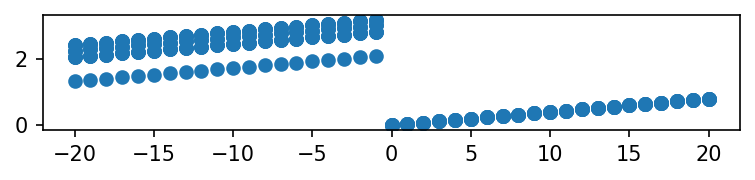

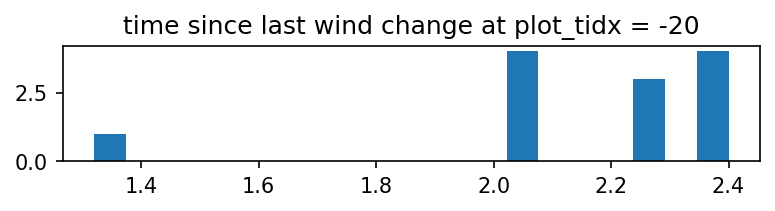

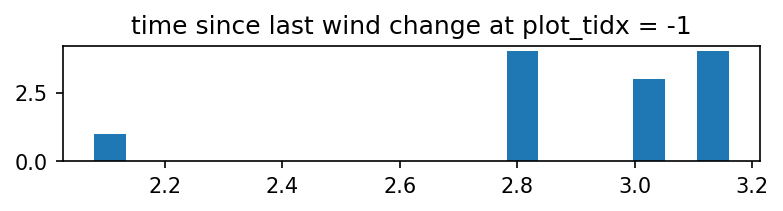

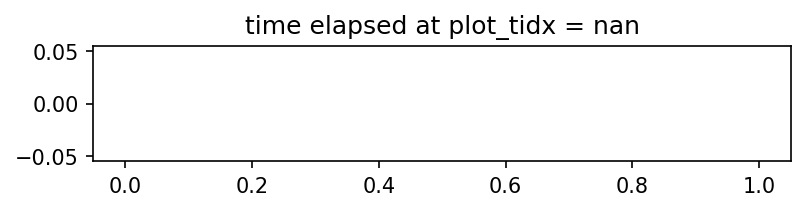

In [61]:
# plot y axis time since last wind change, x axis plot_tidx
import matplotlib.pyplot as plt
subset_df = df_test_around.copy()
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)

plt.scatter(subset_df['plot_tidx'], subset_df['time_since_last_wind_change'])

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = df_test_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == subset_df['plot_tidx'].min()]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time_since_last_wind_change'], bins=20)
plt.title(f"time since last wind change at plot_tidx = {subset_df['plot_tidx'].min()}")

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = df_test_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == -1]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time_since_last_wind_change'], bins=20)
plt.title(f"time since last wind change at plot_tidx = {subset_df['plot_tidx'].min()}")

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = df_test_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == -30]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time'], bins=20)
plt.title(f"time elapsed at plot_tidx = {subset_df['plot_tidx'].min()}") # use this to pick threshold for drop_close_to_trial_init


In [109]:
df_test_around.columns

Index(['ep_idx', 'time', 'app_wind_x', 'app_wind_y', 'odor', 'allo_head_phi_x',
       'allo_head_phi_y', 'ego_drift_x', 'ego_drift_y', 'acceleration_x',
       'angular_acceleration_x', 'step', 'step_dt', 'speed', 'acceleration_y',
       'turn', 'angular_velocity_turn', 'heading_phi', 'heading_phi_unwrap',
       'angular_velocity', 'angular_acceleration_y', 'time_initial', 'v_para',
       'v_perp', 'w', 'zeta', 'time_since_last_wind_change', 'odor_01',
       'state_prob_0', 'state_prob_1', 'state_prob_2', 'state', 'step_hat',
       'turn_hat', 'step_error', 'step_error_abs', 'turn_error',
       'turn_error_abs', 'plot_tidx'],
      dtype='object')

(2, 1)


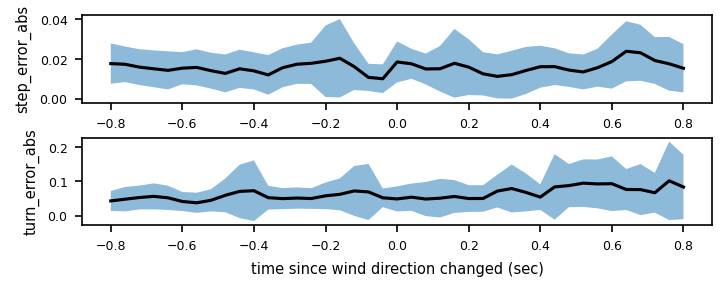

In [113]:
subset_df = df_test_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx').mean().reset_index()
col_vars = ['step_error_abs', 'turn_error_abs']
# get std and ste of the columns
for col in col_vars:
    subset_df[f'{col}_std'] = df_test_around.groupby('plot_tidx').std().reset_index()[col]
    subset_df[f'{col}_ste'] = df_test_around.groupby('plot_tidx').sem().reset_index()[col]
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04


n_state = len(col_vars)
import matplotlib.pyplot as plt
import matplotlib as mpl
# from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'

max_y = np.max(subset_df[col_vars].values)
min_y = np.min(subset_df[col_vars].values)

log_tick_high = int(np.ceil(np.log10(max_y)))
log_tick_low = int(np.floor(np.log10(min_y)))
# cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, col_name in enumerate(col_vars):
    ax[n, 0].plot(subset_df['plot_tidx'], subset_df[col_name].values, color='black')

    # colorline(subset_df['plot_tidx'], subset_df[col_name].values, subset_df[col_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[col_name].values-subset_df[f'{col_name}_std'], subset_df[col_name].values+subset_df[f'{col_name}_std'], alpha=0.5)
    # Colorbar
    # cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    # cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        # ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    # cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    # cbar.ax.tick_params(labelsize=6)

    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, 4 ))
    ax[n, 0].set_ylabel(col_name, fontsize=7)


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

# plt.show()
# plt.savefig('/src/tools/pybounds/examples/plots/obs.png')

## R^2 around time of wind change

In [ ]:
df_test_around

In [ ]:
subset_df = df_test_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx').mean().reset_index()
# subset_df['std'] = df_test_around.groupby('plot_tidx').std().reset_index()['zeta']
# subset_df['ste'] = df_test_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04

col_vars = ['state_prob_0', 'state_prob_1', 'state_prob_2']
n_state = len(col_vars)
import matplotlib.pyplot as plt
import matplotlib as mpl
# from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'

max_y = np.max(subset_df[['state_prob_0', 'state_prob_1', 'state_prob_2']].values)
min_y = np.min(subset_df[['state_prob_0', 'state_prob_1', 'state_prob_2']].values)

log_tick_high = int(np.ceil(np.log10(max_y)))
log_tick_low = int(np.floor(np.log10(min_y)))
# cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, col_name in enumerate(col_vars):
    ax[n, 0].plot(subset_df['plot_tidx'], subset_df[col_name].values, color='black')

    # colorline(subset_df['plot_tidx'], subset_df[col_name].values, subset_df[col_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    # ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[col_name].values-subset_df['ste'], subset_df[col_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    # cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    # cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        # ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    # cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    # cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(col_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, 4 ))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

# plt.show()
# plt.savefig('/src/tools/pybounds/examples/plots/obs.png')

# visualize GLM weights

## plot one model

In [20]:
w_pred_K3 = w_pred_all[0] # shape (3, 3, 8, 2): model, K, D+1, dim_output
w_pred = w_pred_K3[2] # shape (3, 8, 2): K, D+1, dim_output

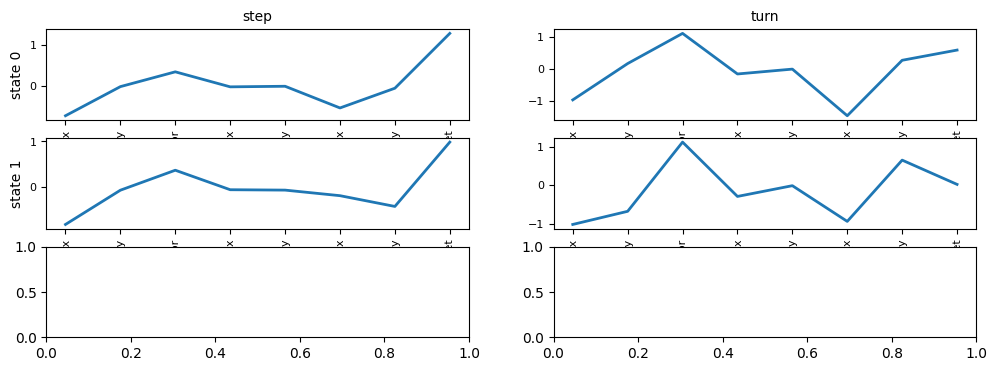

In [21]:
# plot the inferred weights probabilities
# fig, axes = plt.f
fig, axes = plt.subplots(3,2)
output_names=['step', 'turn']
for state_i in range(w_pred.shape[0]):
    for output_i in range(w_pred.shape[2]):
    # state_i = 0
    # output_i = 0
        ax = axes[state_i, output_i]

        fig.set_size_inches(12, 4)
        colors = np.array([[0,0,0]])/255
        xlabels = ['app_wind_x', 'app_wind_y', 
                    'odor', 
                    'allo_head_phi_x', 'allo_head_phi_y', 
                    'ego_drift_x', 'ego_drift_y', 'offset'
                    # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                    ]
        # w_pred.shape (3, 8, 2): K, D+1, dim_output
        style = '-'
        ax.plot(w_pred[state_i,:,output_i], style,linewidth=2) #,color=color[i] label=label[i],
        # label x axis by name
        ax.set_xticks(np.arange(0,len(xlabels)))
        ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
        # change y ticks font
        ax.tick_params(axis='y', labelsize=8)
        # change y label font
        if output_i == 0:
            ax.set_ylabel(f"state {state_i}" , fontsize=10)
        if state_i == 0:
            ax.set_title(f'{output_names[output_i]}', fontsize=10)
# label the first column
# axes[0,0].set_title('state 0')
# axes[1,0].set_title('state 1')
# axes[2,0].set_title('state 2')
# plt.tight_layout()

    
# if color is not None:
#     if error is not None:
#         error = error[(w.shape[0])*(w.shape[0]-1):]
#         error = np.reshape(error,(w.shape[0],w.shape[1]))
#         for i in range(w.shape[0]):
#             ax.errorbar(np.arange(w[i,:].shape[0]),w[i,:],yerr=error[i,:],fmt=style,color=color[i],label=label[i],linewidth=2)
#     else:
#         for i in range(w.shape[0]):
#             ax.plot(w[i,:],style,color=color[i],label=label[i],linewidth=2)
# else:
#     if error is not None:
#         ax.errorbar(w.T,yerr=error,fmt=style,label=label)
#     else:
#         ax.plot(w.T,style,label=label)
# ax.set_ylabel('weight')
# if xlabels:
#     ax.plot(xlabels,np.zeros((len(xlabels),1)),'k--')
#     ax.set_xticks(np.arange(0,len(xlabels)))
#     ax.set_xticklabels(xlabels,rotation=90)
        
        
# plot_weights(w_pred.reshape(1,-1),axes[0],switch=True,xlabels=xlabels,style='.-',color=colors)
# axes[0].text(0.43,-0.25,'prev choice',transform=axes[0].transAxes)
# axes[0].set_title('indirect pathway')
# axes[0].set_ylim([-1,1])
# axes[0].set_yticks(np.arange(-1,1.5,0.5))



## plot all K3 models

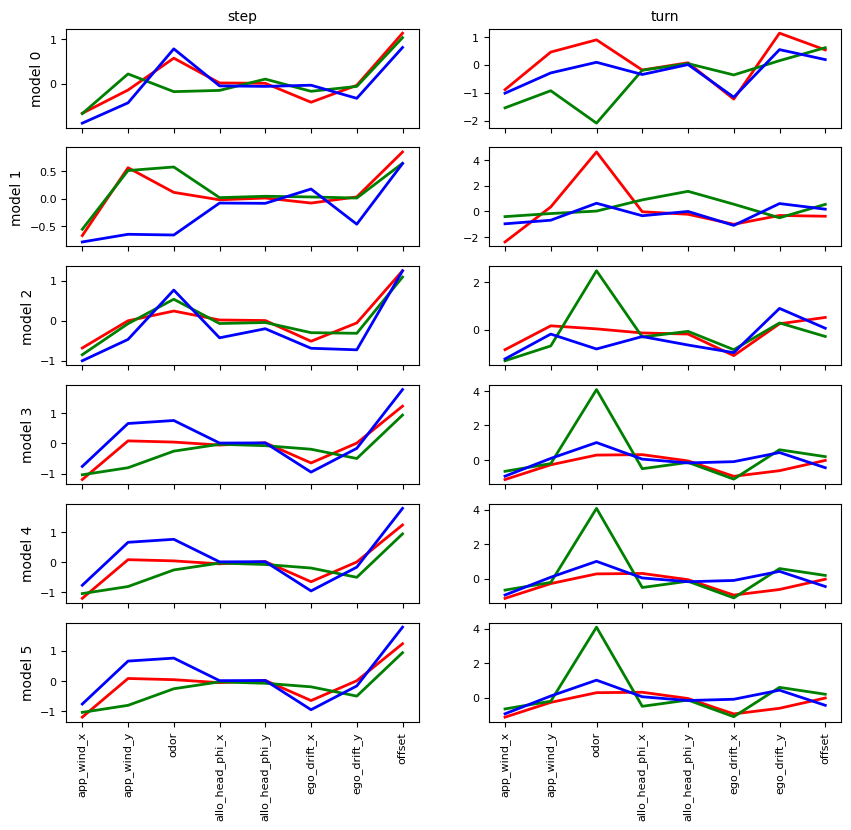

In [22]:
for w_pred in w_pred_all:
    if w_pred.shape[1] == 3:
        w_pred_K3 = w_pred

# plot the inferred weights probabilities


fig, axes = plt.subplots(w_pred_K3.shape[0],2)
# set figure size
fig.set_size_inches(10,9)
output_names=['step', 'turn']
# set up a colors obj with 3 distinct colors , without using sns
colors = ['r', 'g', 'b']
labels = ['state 0', 'state 1', 'state 2']
for model_i in range(w_pred_K3.shape[0]):
    w_pred = w_pred_K3[model_i] # shape (3, 8, 2): K, D+1, dim_output
    for state_i in range(w_pred.shape[0]):
        for output_i in range(w_pred.shape[2]):
            ax = axes[model_i, output_i] # each model has its own row
            xlabels = ['app_wind_x', 'app_wind_y', 
                        'odor', 
                        'allo_head_phi_x', 'allo_head_phi_y', 
                        'ego_drift_x', 'ego_drift_y', 'offset'
                        # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                        ]
            # w_pred.shape (3, 8, 2): K, D+1, dim_output
            style = '-'
            # print("w_pred[state_i,:,output_i].shape", w_pred[state_i,:,output_i].shape)
            # print("labels[state_i]", labels[state_i])
            # print("colors[state_i]", colors[state_i])
            ax.plot(w_pred[state_i,:,output_i], style,linewidth=2, color=colors[state_i], label=labels[state_i]) #,color=color[i] label=label[i],
            # label x axis by name
            ax.set_xticks(np.arange(0,len(xlabels)))
            ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
            # change y ticks font
            ax.tick_params(axis='y', labelsize=8)
            # change y label font
            if output_i == 0:
                ax.set_ylabel(f"model {model_i}" , fontsize=10)
            if model_i == 0:
                ax.set_title(f'{output_names[output_i]}', fontsize=10)
            if model_i != w_pred_K3.shape[0]-1:
                ax.set_xticklabels([])


## plot all K2 models

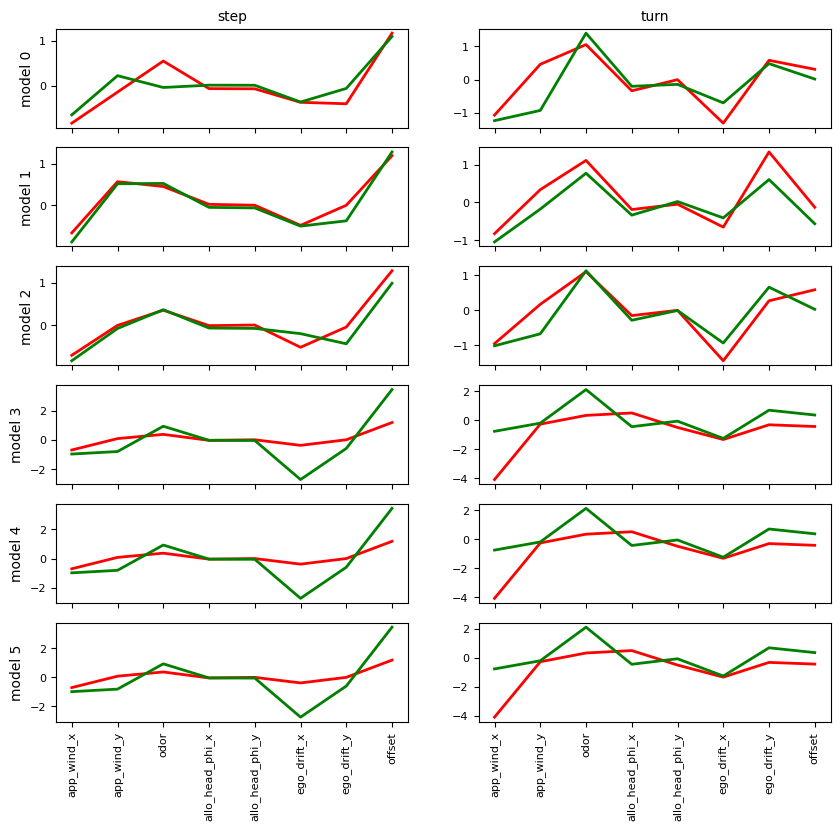

In [23]:
for w_pred in w_pred_all:
    if w_pred.shape[1] == 2:
        w_pred_K2 = w_pred


# plot the inferred weights probabilities


fig, axes = plt.subplots(w_pred_K2.shape[0],2)
# set figure size
fig.set_size_inches(10,9)
output_names=['step', 'turn']
# set up a colors obj with 3 distinct colors , without using sns
colors = ['r', 'g', 'b']
labels = ['state 0', 'state 1', 'state 2']
for model_i in range(w_pred_K2.shape[0]):
    w_pred = w_pred_K2[model_i] # shape (3, 8, 2): K, D+1, dim_output
    for state_i in range(w_pred.shape[0]):
        for output_i in range(w_pred.shape[2]):
            ax = axes[model_i, output_i] # each model has its own row
            xlabels = ['app_wind_x', 'app_wind_y', 
                        'odor', 
                        'allo_head_phi_x', 'allo_head_phi_y', 
                        'ego_drift_x', 'ego_drift_y', 'offset'
                        # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                        ]
            # w_pred.shape (3, 8, 2): K, D+1, dim_output
            style = '-'
            # print("w_pred[state_i,:,output_i].shape", w_pred[state_i,:,output_i].shape)
            # print("labels[state_i]", labels[state_i])
            # print("colors[state_i]", colors[state_i])
            ax.plot(w_pred[state_i,:,output_i], style,linewidth=2, color=colors[state_i], label=labels[state_i]) #,color=color[i] label=label[i],
            # label x axis by name
            ax.set_xticks(np.arange(0,len(xlabels)))
            ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
            # change y ticks font
            ax.tick_params(axis='y', labelsize=8)
            # change y label font
            if output_i == 0:
                ax.set_ylabel(f"model {model_i}" , fontsize=10)
            if model_i == 0:
                ax.set_title(f'{output_names[output_i]}', fontsize=10)
            if model_i != w_pred_K2.shape[0]-1:
                ax.set_xticklabels([])


## plot all K4 models

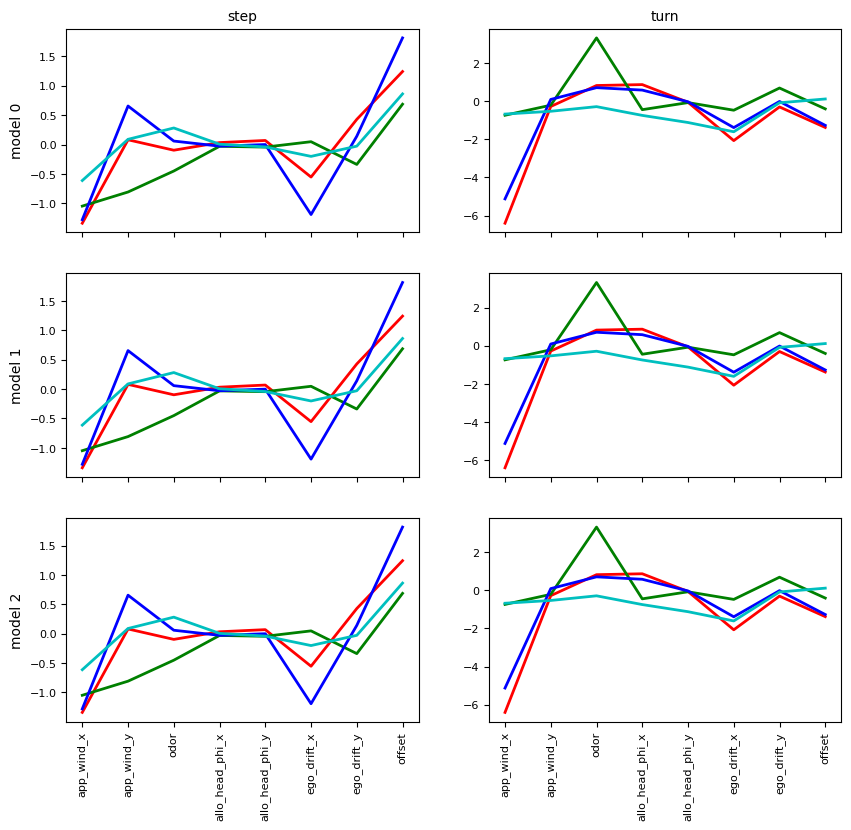

In [24]:
for w_pred in w_pred_all:
    if w_pred.shape[1] == 4:
        plot_w = w_pred


# plot the inferred weights probabilities


fig, axes = plt.subplots(plot_w.shape[0],2)
# set figure size
fig.set_size_inches(10,9)
output_names=['step', 'turn']
# set up a colors obj with 3 distinct colors , without using sns
colors = ['r', 'g', 'b', 'c']
labels = ['state 0', 'state 1', 'state 2', 'state 3']
for model_i in range(plot_w.shape[0]):
    w_pred = plot_w[model_i] # shape (3, 8, 2): K, D+1, dim_output
    for state_i in range(w_pred.shape[0]):
        for output_i in range(w_pred.shape[2]):
            ax = axes[model_i, output_i] # each model has its own row
            xlabels = ['app_wind_x', 'app_wind_y', 
                        'odor', 
                        'allo_head_phi_x', 'allo_head_phi_y', 
                        'ego_drift_x', 'ego_drift_y', 'offset'
                        # 'min_EV_zeta', 'time_since_last_wind_change', 'acceleration', 'angular_acceleration'
                        ]
            # w_pred.shape (3, 8, 2): K, D+1, dim_output
            style = '-'
            # print("w_pred[state_i,:,output_i].shape", w_pred[state_i,:,output_i].shape)
            # print("labels[state_i]", labels[state_i])
            # print("colors[state_i]", colors[state_i])
            ax.plot(w_pred[state_i,:,output_i], style,linewidth=2, color=colors[state_i], label=labels[state_i]) #,color=color[i] label=label[i],
            # label x axis by name
            ax.set_xticks(np.arange(0,len(xlabels)))
            ax.set_xticklabels(xlabels,rotation=90, fontsize=8)
            # change y ticks font
            ax.tick_params(axis='y', labelsize=8)
            # change y label font
            if output_i == 0:
                ax.set_ylabel(f"model {model_i}" , fontsize=10)
            if model_i == 0:
                ax.set_title(f'{output_names[output_i]}', fontsize=10)
            if model_i != plot_w.shape[0]-1:
                ax.set_xticklabels([])
